[Google Collab](https://www.githubtocolab.com/wilsonnguyen5163/INSE6220/blob/main/Project.ipynb)

In [209]:
import pycaret
import sklearn
import numpy as np
import math
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# sklearn offer a more customizable pca method, while pca.pca is simplier and offer built-in visualizer
from pca import pca


# **Load dataset**

In [2]:
data = pd.read_csv(r'ai4i2020.csv')
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# **Understanding the data**

**Dataset**:
- *TWF*, *HDF*, *PWF*, *OSF*, *RNF* are extensions of *Machine failure* aiming to provide more meaning for when a machine fails.
  - If any of the one-hot error feature value is 1, then *Machine failure* = 1 for that object
- *UDI*, *Product ID* are identifiers and hence are not useful for training purposes
- *Type* specifies the product quality variants. This feature derives from *Product ID*
  - There is an intrinsic hierarchy, as L = low quality, M = medium quality, H = high quality, so we assign increasing integer value for each.
  - Note that we are not considering this feature for PCA purposes, since it is not continuous but only a category of the object

In [3]:
X = data.drop(columns=["UDI", "Product ID", "Type", "TWF", "HDF", "PWF", "OSF", "RNF", "Machine failure"])
y = data['Machine failure']

In [4]:
X

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,298.1,308.6,1551,42.8,0
1,298.2,308.7,1408,46.3,3
2,298.1,308.5,1498,49.4,5
3,298.2,308.6,1433,39.5,7
4,298.2,308.7,1408,40.0,9
...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14
9996,298.9,308.4,1632,31.8,17
9997,299.0,308.6,1645,33.4,22
9998,299.0,308.7,1408,48.5,25


In [5]:
X.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


**Quick Insight**: Rotational speed and tool wear have large variance

In [6]:
y.value_counts()

Machine failure
0    9661
1     339
Name: count, dtype: int64

**Boxplot**

**Standardize** the dataset

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns = X.columns

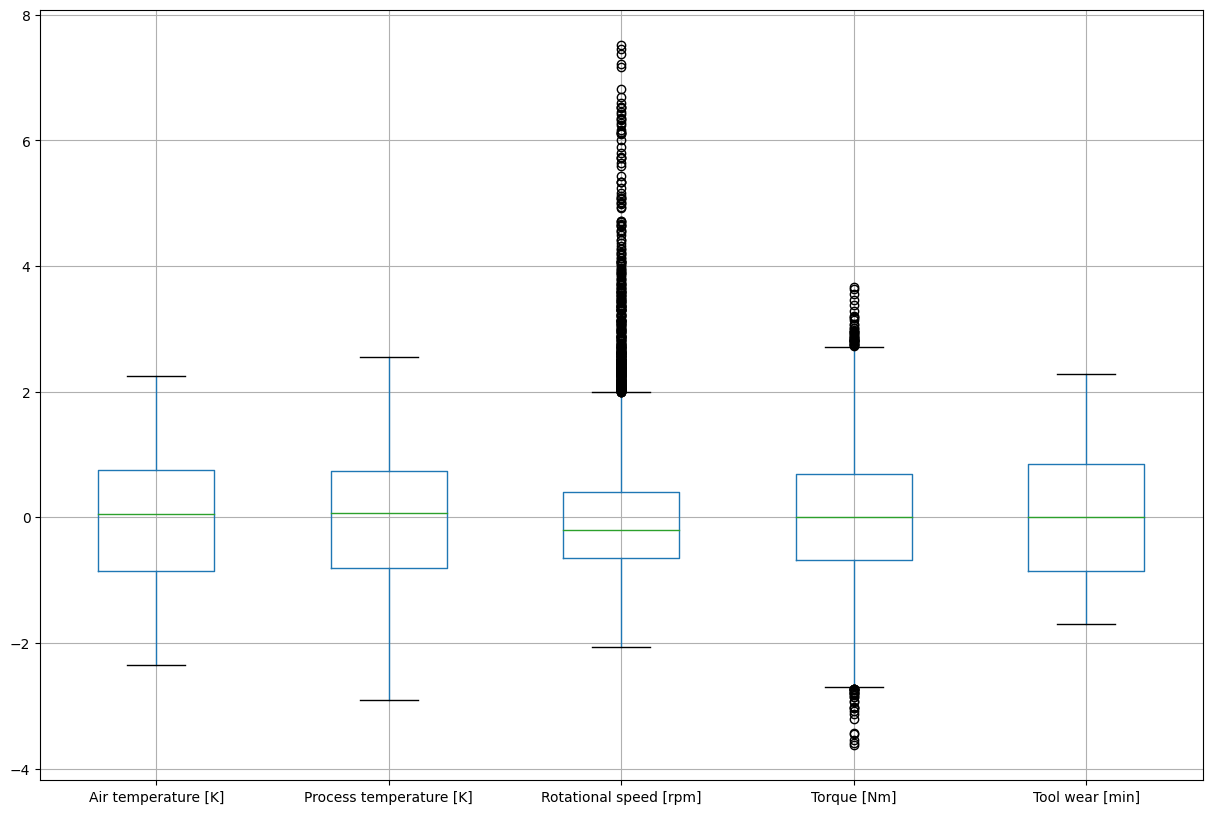

In [8]:
X_scaled.boxplot(figsize=(15,10))
plt.show()

**Insight**: 
- 4/5 features are normally distributed (ignore type)
  - Torque [Nm] seemingly show a normally distributed with quite a few outliers, equally on both ends of the tail
- Rotational speed [rpm] shows a more heavily positive-skewed (right skewed) with all outliers on the right-end of the tail. 

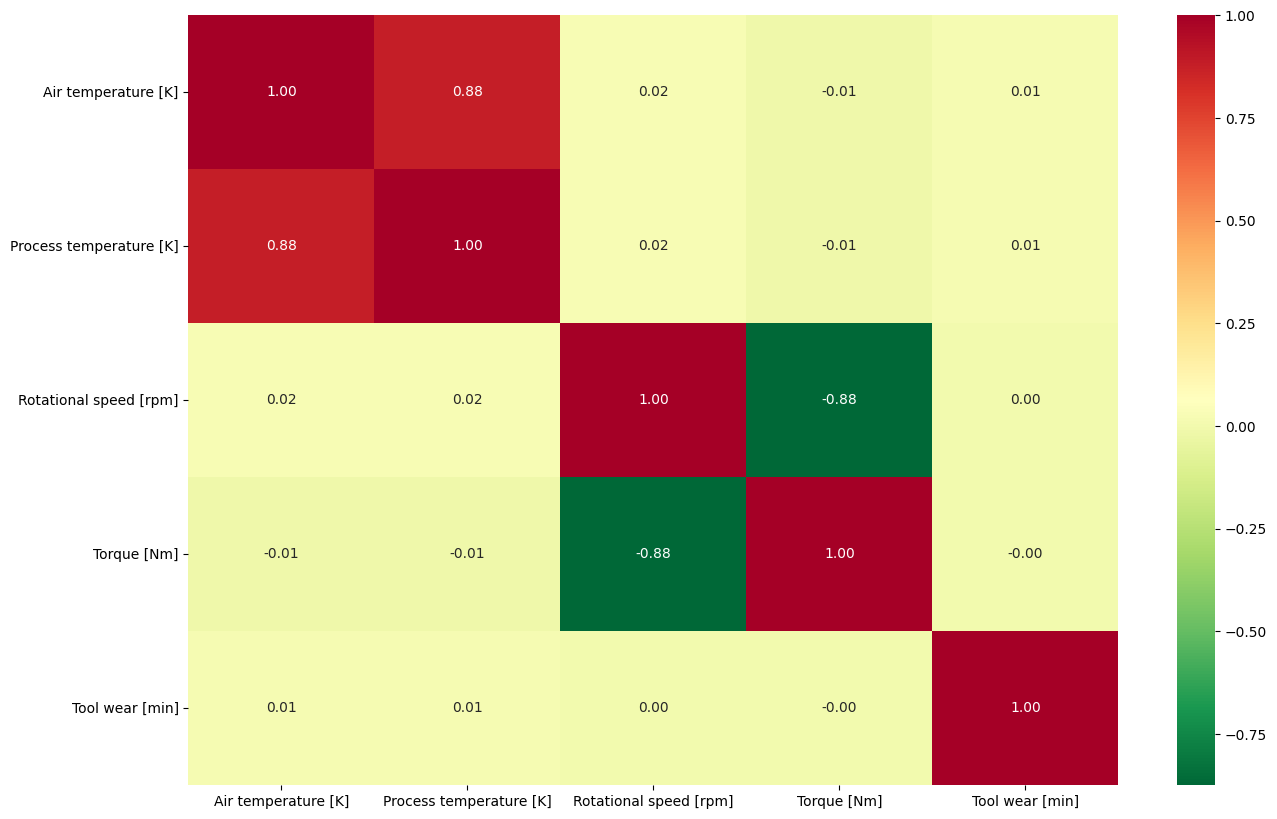

In [9]:
corr_matrix = X.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn_r', fmt='.2f')
plt.show()

**Insight**: 
- Process temprature [K] high positively correlated to Air temperature [K]  
- Rotational Speed [K] high negatively correlated to Torque [Nm]  

Heavily correlated features may be considered for removal for better generalization / visualization of the dataset

**Pair plot** confirms the correlations between the 2 pairs

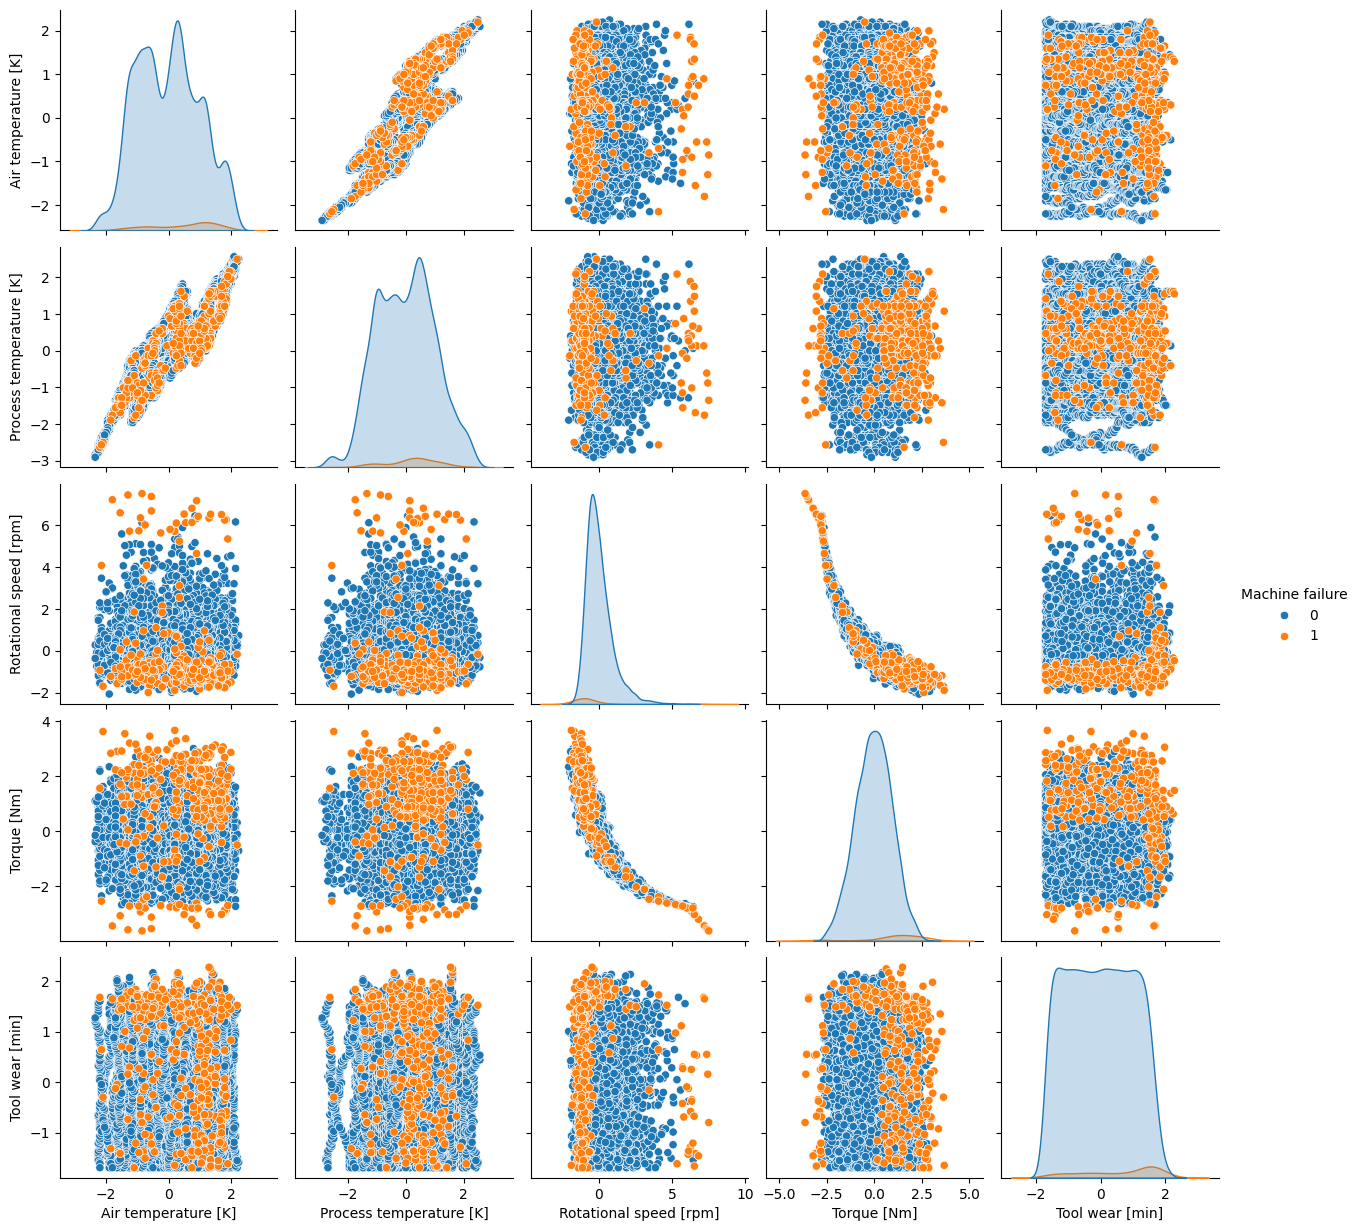

In [10]:
# Temporary sort the dataframe so that we can see the minority class (machines that failed) plot later, for visualization purposes
sns.pairplot(pd.concat([X_scaled, y], axis=1).sort_values(by="Machine failure", ascending=True), hue="Machine failure")
plt.show()

# **PCA**


In [219]:
pca_model = pca(n_components=0.90)
pca_transformed = pca_model.fit_transform(X_scaled)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [90.0%] explained variance using the [5] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [3] that covers the [90.00%] explained variance.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


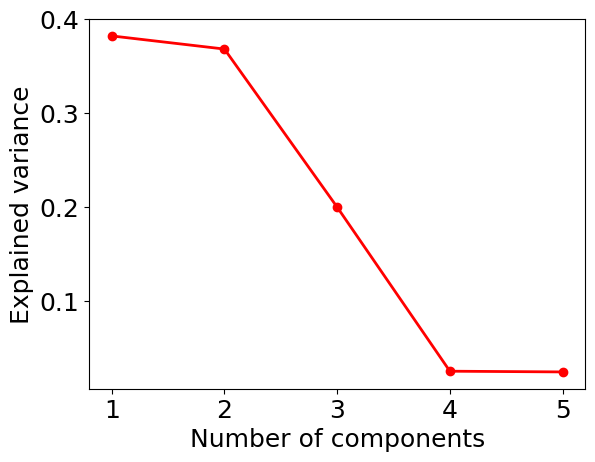

In [220]:
VR = pca_transformed['variance_ratio']
x = np.arange(len(VR)) + 1
plt.plot(x, VR, 'ro-', lw=2)
plt.xticks(x, [""+str(i) for i in x], rotation=0)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

In [221]:
VR

array([0.3821481 , 0.36817048, 0.19991526, 0.02526552, 0.02450064])

**Cumulative Variance Plot**: 
- The bars represents individual principle component's contribution to explaining the variance of data
- The line on top represents the culmulative variance explained by the principle components

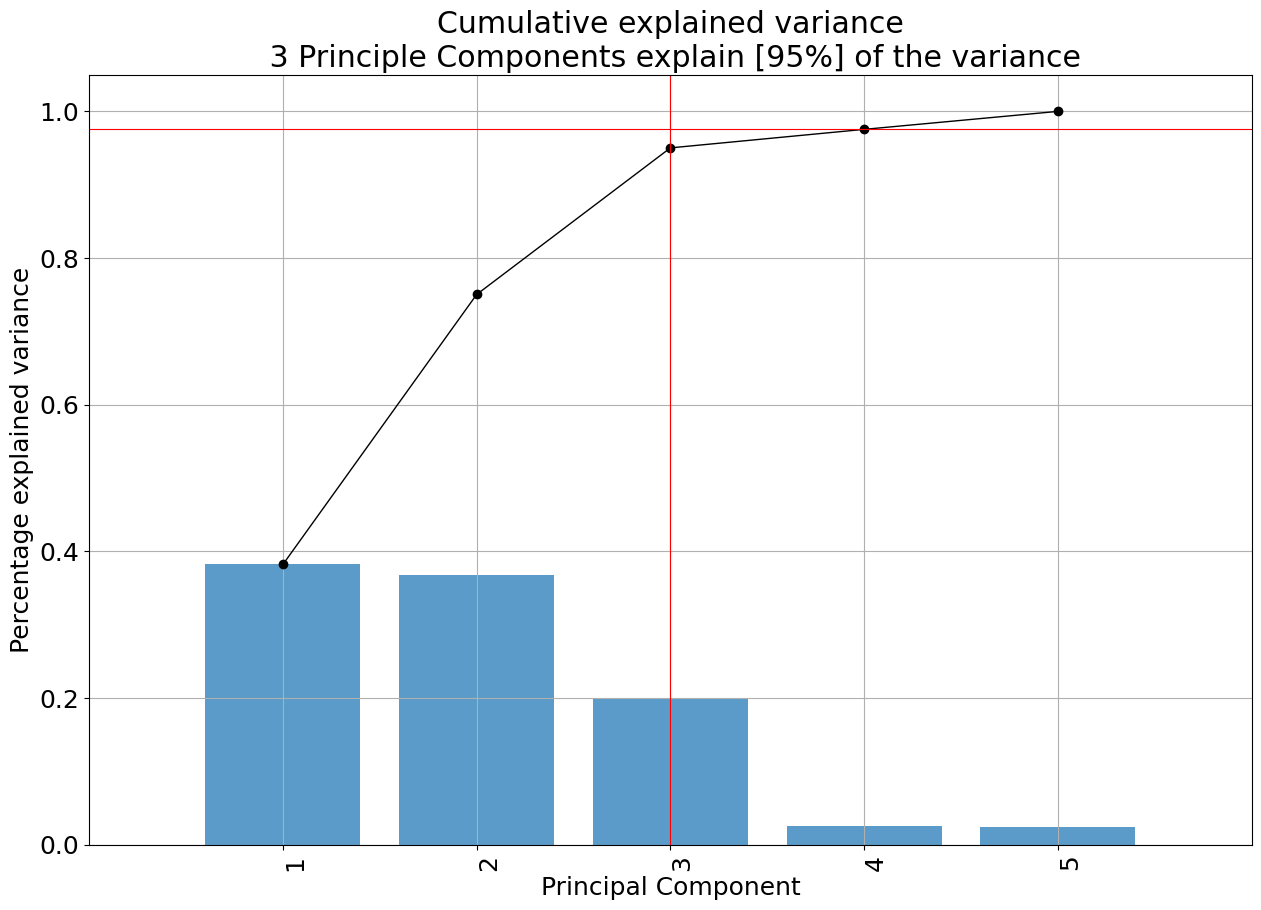

In [230]:
pca_model.plot(title="Cumulative explained variance\n 3 Principle Components explain [95%] of the variance")
plt.show()

**Insight**: we observe a clear elbow point at PC3, and we see that the first 3 principle components explain ~ 97% of the dataset's total variance
- Goal of PCA is to pick a reduced number of features (r < k) of the original k-features, that captures 'significant' number of variance of the dataset
  - This simplify classification results and improve model's performance.
- From this cumulative variance plot, we can agree on r = 3 is sufficient in capturing the majority (~ 95%) of the data's variance (can confirm below)

In [217]:
pca_transformed['explained_var']

array([0.3821481 , 0.75031858, 0.95023384, 0.97549936, 1.        ])

In [93]:
pca_model = pca(n_components=3)
X_pca_transformed = pca_model.fit_transform(X_scaled)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


In [232]:
X_pca_transformed['variance_ratio']

array([0.3821481 , 0.36817048, 0.19991526])

In [233]:
X_pca_transformed['explained_var']

array([0.3821481 , 0.75031858, 0.95023384])

In [244]:
pca_projected_X = X_pca_transformed['PC'].to_numpy()
features = X_pca_transformed['loadings'].columns

In [235]:
pca_loading = X_pca_transformed['loadings'].to_numpy().T
pca_loading

array([[ 5.05733117e-01, -4.93938038e-01, -1.53244151e-02],
       [ 5.04864639e-01, -4.94846528e-01, -1.57295452e-02],
       [ 4.96477652e-01,  5.03423000e-01, -3.03981958e-03],
       [-4.92511825e-01, -5.07463604e-01, -4.90137362e-04],
       [ 1.69633307e-02, -1.40748951e-02,  9.99754101e-01]])

In [236]:
top_influences= pca_model.compute_topfeat()
top_influences

,PC,feature,loading,type
0,PC1,Air temperature [K],0.505733,best
1,PC2,Torque [Nm],-0.507464,best
2,PC3,Tool wear [min],0.999754,best
3,PC1,Process temperature [K],0.504865,weak
4,PC2,Rotational speed [rpm],0.503423,weak


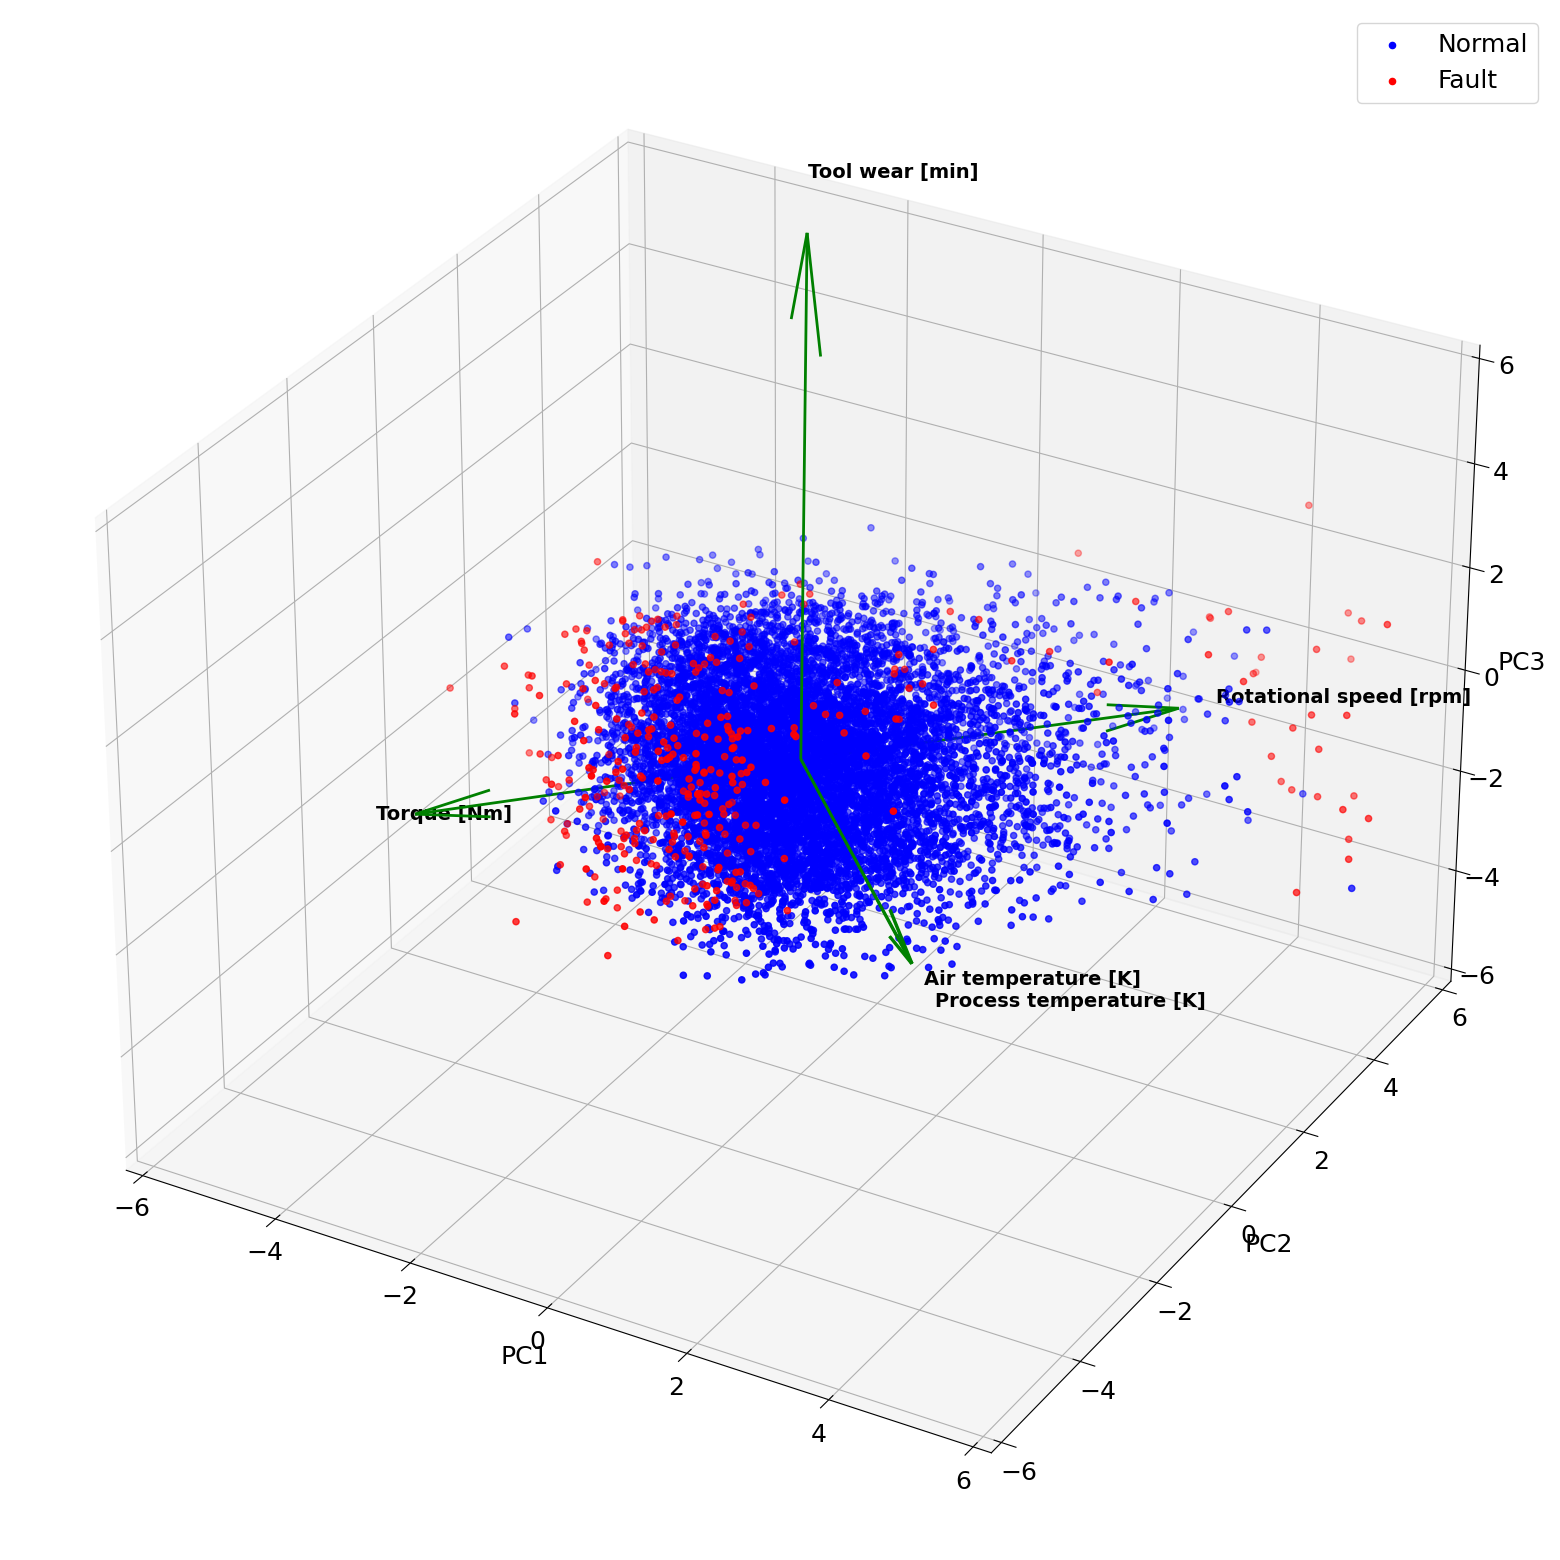

In [246]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(25,20))
ax = fig.add_subplot(111, projection='3d')

scatter_normal = ax.scatter(pca_projected_X[y == 0, 0], pca_projected_X[y == 0, 1],
                      pca_projected_X[y == 0, 2], c='blue', label='Normal')

# Scatter plot for Label 1 (color them red)
scatter_fault = ax.scatter(pca_projected_X[y == 1, 0], pca_projected_X[y == 1, 1],
                      pca_projected_X[y == 1, 2], c='red', label='Fault')
ax.legend()

for i in range(pca_loading.shape[0]):
    ax.quiver(0, 0, 0, pca_loading[i, 0], pca_loading[i, 1], pca_loading[i, 2],
              length=np.linalg.norm(pca_loading[i])*10, color='green', arrow_length_ratio=0.2, linewidth=2)
    if (i == 1):
        ax.text(pca_loading[i, 0]*np.linalg.norm(pca_loading[i])*12, pca_loading[i, 1]*np.linalg.norm(pca_loading[i])*12, pca_loading[i, 2]*np.linalg.norm(pca_loading[i])*12,
                f'{features[i]}', color='black', fontsize=14, fontweight='bold')
    else:
        ax.text(pca_loading[i, 0]*np.linalg.norm(pca_loading[i])*11, pca_loading[i, 1]*np.linalg.norm(pca_loading[i])*11, pca_loading[i, 2]*np.linalg.norm(pca_loading[i])*11,
                f'{features[i]}', color='black', fontsize=14, fontweight='bold')
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.set_xlim([-6, 6])  # Adjust the x-axis limit
ax.set_ylim([-6, 6])  # Adjust the y-axis limit
ax.set_zlim([-6, 6])  # Adjust the z-axis limit


# Show the plot
plt.legend()
plt.show()

**Insight**: the individual feature vector helps visualize how each feature influences the score of Principle Components along the PC's respective axis (the correlation between the feature and PCs)
- Notice air temperature and process temperature influences roughly in the same direction, we can verify by looking at the loadings, that air temperature and process temperature columns are almost identical

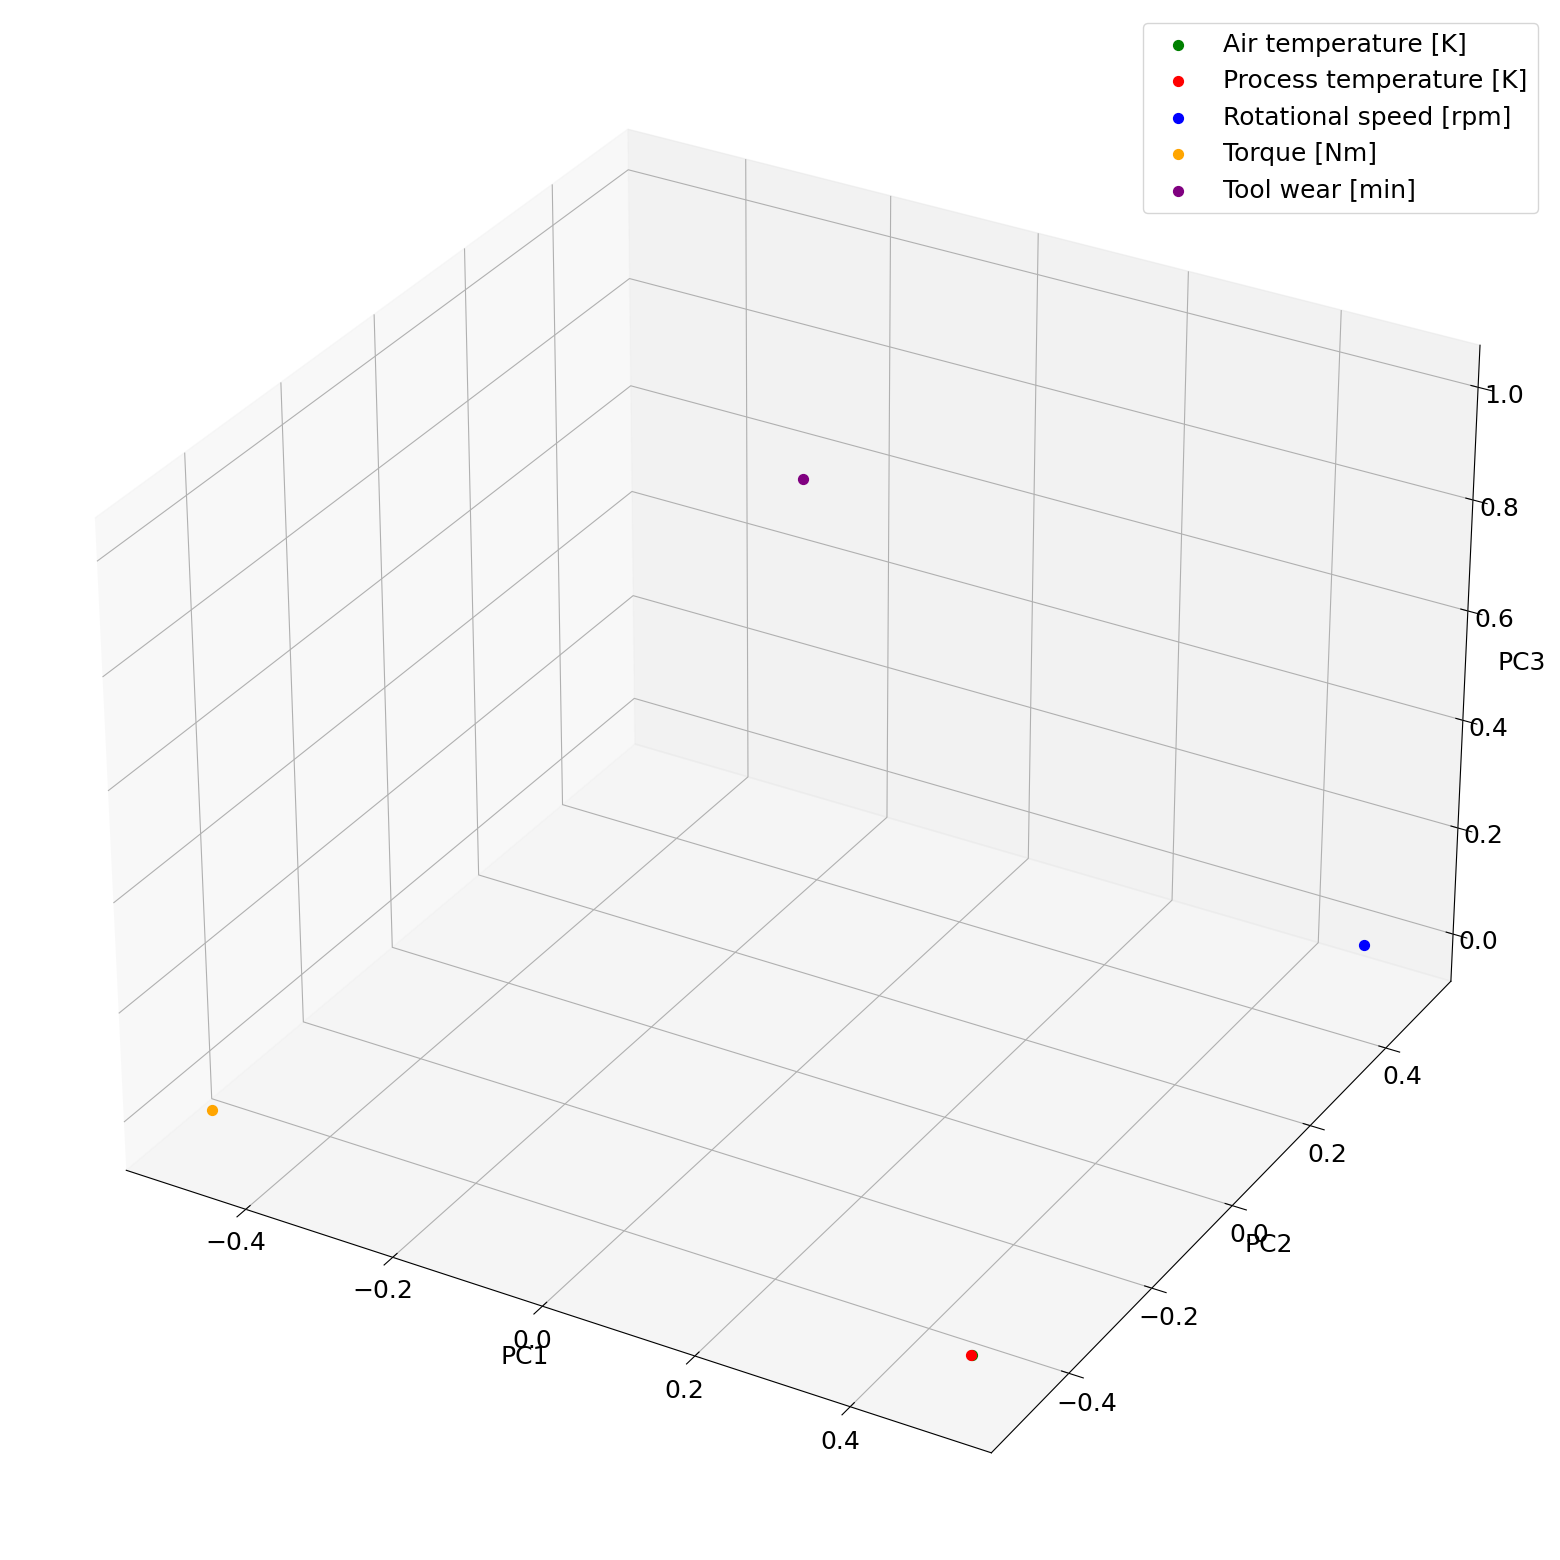

In [266]:
fig = plt.figure(figsize=(25, 20))
ax = fig.add_subplot(111, projection='3d')



ax.scatter( pca_loading[0, 0], pca_loading[0, 1], pca_loading[0, 2], s=50,
            color='green', label="Air temperature [K]")
ax.scatter(pca_loading[1, 0], pca_loading[1, 1], pca_loading[1, 2], s=50,
           color='red', label="Process temperature [K]")
ax.scatter(pca_loading[2, 0], pca_loading[2, 1], pca_loading[2, 2], s=50,
           color='blue', label="Rotational speed [rpm]")
ax.scatter(pca_loading[3, 0], pca_loading[3, 1], pca_loading[3, 2], s=50,
           color='orange', label="Torque [Nm]")
ax.scatter(pca_loading[4, 0], pca_loading[4, 1], pca_loading[4, 2], s=50,
           color='purple', label="Tool wear [min]")
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')


# Show the plot
plt.legend()
plt.show()

**Obtaining the 3 Principle Components**

In [90]:
X_pca_transformed['loadings']

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
PC1,0.505733,0.504865,0.496478,-0.492512,0.016963
PC2,-0.493938,-0.494847,0.503423,-0.507464,-0.014075
PC3,-0.015324,-0.015730,-0.003040,-0.000490,0.999754
